<center><h2>Snake Arcade Game - DQN Algorithm</h2></center>

### Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


import gym
from gym import spaces


# Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

# import cv2
import random
import time
from collections import deque

### Defining functions for visualizations

In [2]:
    
def viz_game(snake_photo, snake_position, apple_position, snake_head, head_direction):
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.gca()
    ax.set_facecolor('#FFF9C4')

    plt.xlim([0, 150])
    plt.ylim([0, 150])

    plt.xticks(np.arange(0, 151, 10))
    plt.yticks(np.arange(0, 151, 10))

    ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


#     ax.grid(True, linewidth=0.5, color='gray', linestyle='-')
   # Plotting Apple
    img = plt.imread("/kaggle/input/snakegr1/Snake_Graphics1/apple.png")
    
    snakehead_r = plt.imread("/kaggle/input/snakegr1/Snake_Graphics1/snake_hd_rt.png")
    snakehead_l = plt.imread("/kaggle/input/snakegr1/Snake_Graphics1/snake_hd_lft.png")
    snakehead_d = plt.imread("/kaggle/input/snakegr1/Snake_Graphics1/snake_hd_dn.png")
    snakehead_u = plt.imread("/kaggle/input/snakegr1/Snake_Graphics1/snake_hd_up.png")
    
    snakebodyimg = plt.imread("/kaggle/input/snakegr1/Snake_Graphics1/body.png")

    
    ax.imshow(img, extent=[apple_position[0], apple_position[0]+10, apple_position[1], apple_position[1]+10])

    if snake_photo == 'right':
        ax.imshow(snakehead_r, extent=[snake_head[0], snake_head[0]+10, snake_head[1], snake_head[1]+10])
        for position in snake_position[1:]:
            ax.imshow(snakebodyimg, extent=[position[0], position[0]+10, position[1], position[1]+10])
        
    elif snake_photo == 'left':
        ax.imshow(snakehead_l, extent=[snake_head[0], snake_head[0]+10, snake_head[1], snake_head[1]+10])
        for position in snake_position[1:]:
            ax.imshow(snakebodyimg, extent=[position[0], position[0]+10, position[1], position[1]+10])
            
    elif snake_photo == 'down':
        ax.imshow(snakehead_d, extent=[snake_head[0], snake_head[0]+10, snake_head[1], snake_head[1]+10])
        for position in snake_position[1:]:
            ax.imshow(snakebodyimg, extent=[position[0], position[0]+10, position[1], position[1]+10])
#         ax.imshow(snaketail_d, extent=[position[0], position[0]+10, position[1], position[1]+10])
            
    elif snake_photo == 'up':
        ax.imshow(snakehead_u, extent=[snake_head[0], snake_head[0]+10, snake_head[1], snake_head[1]+10])
        for position in snake_position[1:]:
            ax.imshow(snakebodyimg, extent=[position[0], position[0]+10, position[1], position[1]+10])
#         ax.imshow(snaketail_u, extent=[position[0], position[0]+10, position[1], position[1]+10])
        

#     plt.draw()
#     plt.pause(0.001)
#     fig = plt.gcf()
    plt.savefig("frame_%d.png" % action_no)
#     fig.canvas.draw()
#     image = Image.frombytes('RGB', fig.canvas.get_width_height(), 
#                         fig.canvas.tostring_rgb(), 
#                         decoder_name='raw')
    plt.close()


def viz_game_over(apple_count):
    apple_position = [[30,50],[40,50],[50,50],[60,50],[70,50],[80,50],[90,50],[100,50],[110,50],[120,50]]
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.gca()
    ax.set_facecolor('#FFF9C4')

    ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

    plt.xlim([0, 150])
    plt.ylim([0, 150])
    img = plt.imread("/kaggle/input/snakegr1/Snake_Graphics1/apple.png")
    for i in range(apple_count):
        ax.imshow(img, extent=[apple_position[i][0], apple_position[i][0]+10, apple_position[i][1], apple_position[i][1]+10])
    
    
    font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
    ax.text(45, 80, 'Your Apple Count is {}'.format(apple_count), fontdict=font)

    plt.title("Game Over!", fontdict=font)
    plt.savefig("frame_%d.png" % 211)
    
#     plt.show()
    

In [3]:
class Snake(gym.Env):

    def __init__(self, visuals=False):
        super(Snake, self).__init__()
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=-500, high=500, shape=(5+20,), dtype=np.float32)
        self.show_env = visuals
        self.timestep = 0
        self.timestep_max = 4000

    def step(self, action):
        self.prev_actions.append(action)
        self.timestep += 1

#         print("Snake Direction Initial: ",self.head_direction)
#         print("Snake Head Initial: ",self.snake_head)
        
        if action == 0:
            self.head_direction = (self.head_direction + 1) % 4
        elif action == 1:
            self.head_direction = (self.head_direction - 1) % 4
        elif action == 2:
            pass
        
        if self.head_direction == 0:
            self.snake_head[0] += 10
        elif self.head_direction == 1:
            self.snake_head[1] += 10
        elif self.head_direction == 2:
            self.snake_head[0] -= 10
        elif self.head_direction == 3:
            self.snake_head[1] -= 10
            
#         print("Snake Direction After: ",self.head_direction)
#         print("Snake Head After: ",self.snake_head)

        # Increase Snake length on eating apple
        apple_reward = 0
        if self.snake_head == self.apple_position:
            self.apple_count += 1
            self.apple_position = self.apple_position_list[self.apple_count]
            self.snake_position.insert(0,list(self.snake_head))
            apple_reward = 500
            if len(self.snake_position) == MAX_SNAKE_LEN:
                self.reward += 500
                if self.show_env:
                    viz_game_win(self.apple_count)
            
        else:
            self.snake_position.insert(0,list(self.snake_head))
            self.snake_position.pop()
            
        
        if self.show_env:
            viz_game(self.snake_position, self.apple_position, self.snake_head, self.head_direction)
        
        
        # On collision end episode and print the score
        if boundary_collision(self.snake_head) == 1 or self_collision(self.snake_position) == 1:
            if self.show_env:
                viz_game_over(self.apple_count)
            self.done = True
            self.reward = -100


        # REWARD DYNAMICS
        euclidean_dist_to_apple = np.linalg.norm(np.array(self.snake_head) - np.array(self.apple_position))
        self.reward =  (150 - euclidean_dist_to_apple)/10 + apple_reward

        ## if snake dies
#         if self.done:
#             self.reward = -100                                     
        info = {}
    
        if self.timestep == self.timestep_max:
            self.done = True

        head_x = self.snake_head[0]
        head_y = self.snake_head[1]

        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y

        # create observation:
        observation = [head_x, head_y, apple_delta_x, apple_delta_y, snake_length] + list(self.prev_actions)
        observation = np.array(observation)

        return observation, self.reward, self.done, info

    def reset(self):
        
        # Initial Snake and Apple position
        self.snake_position = [[70,80],[60,80],[50,80]]
        self.apple_count = 0
        self.apple_position_list = [[110,60],[50,40],[50,80],[60,110],[70,110],[80,90],[110,60],\
                                    [40,50],[40,80],[40,110],[120,20],[120, 120],[30,120],[90,40],[30,20]]
        self.apple_position = self.apple_position_list[self.apple_count]
        
        self.prev_head_direction = 1
        self.head_direction = 0
        self.snake_head = [70,80]                                                           # head_x and head_y

        self.prev_reward = 0
        self.timestep = 0

        self.done = False                                                                     # Reset the environment after every episode and set done as False

        head_x = self.snake_head[0]
        head_y = self.snake_head[1]

        snake_length = len(self.snake_position)
        apple_delta_x = self.apple_position[0] - head_x
        apple_delta_y = self.apple_position[1] - head_y

        self.prev_actions = deque(maxlen = 20)
        for i in range(20):
            self.prev_actions.append(-1) 

        # create observation:
        observation = [head_x, head_y, apple_delta_x, apple_delta_y, snake_length] + list(self.prev_actions)
        observation = np.array(observation)

        return observation


### Defining helper functions to check if snake is terminated

In [5]:
## Checks if snake has collided with the boundary of the grid
def boundary_collision(snake_head):
     # When snake dimensions go beyond the grid dimensions
    if snake_head[0]>=150 or snake_head[0]<0 or snake_head[1]>=150 or snake_head[1]<0 :
        return 1 # True
    else:
        return 0 # False

    
## Checks if snake has collided with it's own body
def self_collision(snake_position):
    snake_head = snake_position[0]
    if snake_head in snake_position[1:]:
        return 1
    else:
        return 0

In [6]:
## Maximum length of snake before the episode terminates
MAX_SNAKE_LEN = 15

### Training the environment using DQN algorithm

#### Defining the neural network for the agent

In [7]:
class Net(nn.Module):
    def __init__(self, state_size, action_size, learning_rate):
        super(Net, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        self.fc1 = nn.Linear(self.state_size, 84)
        self.fc2 = nn.Linear(84, 84)
        self.fc3 = nn.Linear(84, self.action_size)
        self.relu = nn.ReLU()
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def train_step(self, state, target):
        self.optimizer.zero_grad()
        pred = self.forward(state)
        loss = self.loss_fn(pred, target)
        loss.backward()
        self.optimizer.step()
        return loss.item()


#### Defining the Agent

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size, test=False):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=200000000)
        self.gamma = 0.99   
        self.epsilon = 1.0 if not test else 0.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.0001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = Net(self.state_size, self.action_size, self.learning_rate).to(self.device)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float).to(self.device)
            act_values = self.model(state)
            return np.argmax(act_values.cpu().detach().numpy()[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = torch.tensor(next_state, dtype=torch.float).to(self.device)
                target = (reward + self.gamma *
                          np.amax(self.model(next_state).cpu().detach().numpy()[0]))
            state = torch.tensor(state, dtype=torch.float).to(self.device)
            target_f = self.model(state)
            target_f[0][action] = target
            self.model.train_step(state, target_f)

    def load(self, name):
        self.model.load_state_dict(torch.load(name, map_location=self.device))

    def save(self, name):
        torch.save(self.model.state_dict(), name)


#### Specifying the environment and defining the hyperparameters

In [9]:
env = Snake()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
batch_size = 64
EPISODES = 120000
reward_list_training = []
apple_list_training = []
timestep_list_training = []
eps_list = []
max_apple_count = 1
reached = False

#### Training the agent for defined episodes

In [10]:
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    episode_reward = 0
    timestep = 0
    
    while(not done):
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        timestep+=1
        if done:
            if e % 5000 == 0:
                print("Episode: {}/{}, Episode Reward: {}, Epsilon: {:.2}, Episode Apple Count: {}, Timestep: {}"
                      .format(e, EPISODES, episode_reward, agent.epsilon, env.apple_count, timestep))
            reward_list_training.append(episode_reward)
            apple_list_training.append(env.apple_count)
            timestep_list_training.append(timestep)
            # Saving weights
            agent.save("billodal_syadavil_akhilshr_project_dqn_1.h5")
            break
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
    
    eps_list.append(agent.epsilon)
    if len(agent.memory) > 100000:
        if not reached: # THIS WILL RUN ONLY ONCE
            train_start_at = e
            reached = True
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon = agent.epsilon*((agent.epsilon_min/1)**(1/(EPISODES-train_start_at)))

env.close()

Episode: 0/120000, Episode Reward: 344.37302900121057, Epsilon: 1.0, Episode Apple Count: 0, Timestep: 38
Episode: 5000/120000, Episode Reward: 286.7614203827033, Epsilon: 0.94, Episode Apple Count: 0, Timestep: 35
Episode: 10000/120000, Episode Reward: 388.45779509879696, Epsilon: 0.77, Episode Apple Count: 0, Timestep: 42
Episode: 15000/120000, Episode Reward: 476.6867029252244, Epsilon: 0.63, Episode Apple Count: 0, Timestep: 43
Episode: 20000/120000, Episode Reward: 1656.5808144588989, Epsilon: 0.52, Episode Apple Count: 1, Timestep: 104
Episode: 25000/120000, Episode Reward: 845.295337886633, Epsilon: 0.43, Episode Apple Count: 1, Timestep: 36
Episode: 30000/120000, Episode Reward: 2510.366796507245, Epsilon: 0.35, Episode Apple Count: 2, Timestep: 143
Episode: 35000/120000, Episode Reward: 1478.250506080186, Epsilon: 0.29, Episode Apple Count: 1, Timestep: 84
Episode: 40000/120000, Episode Reward: 2811.620335935563, Epsilon: 0.24, Episode Apple Count: 3, Timestep: 115
Episode: 45

KeyboardInterrupt: 

## Note: Training had to be stopped in the above cell at 115000 episodes for DQN as the Kaggle notebook's runtime was going to end after 12 hours of training

In [16]:
import pickle

with open('reward_list_training.pickle', 'wb') as f:
    pickle.dump(reward_list_training, f)

#### Reward per episode during training

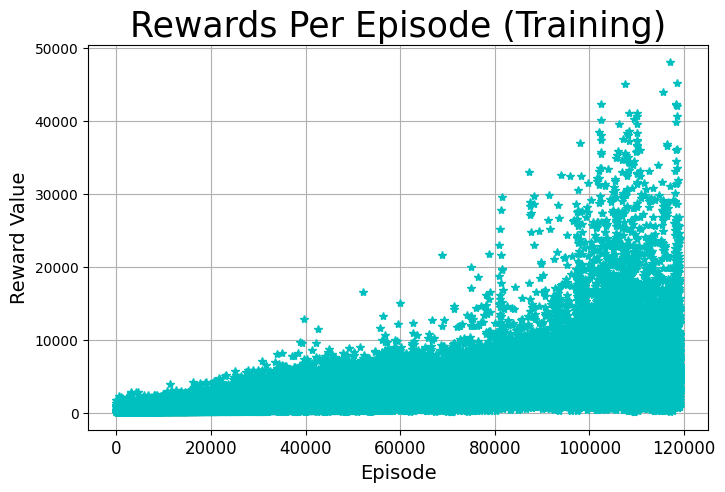

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(reward_list_training, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Reward Value', fontsize=14)
plt.title('Rewards Per Episode (Training)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

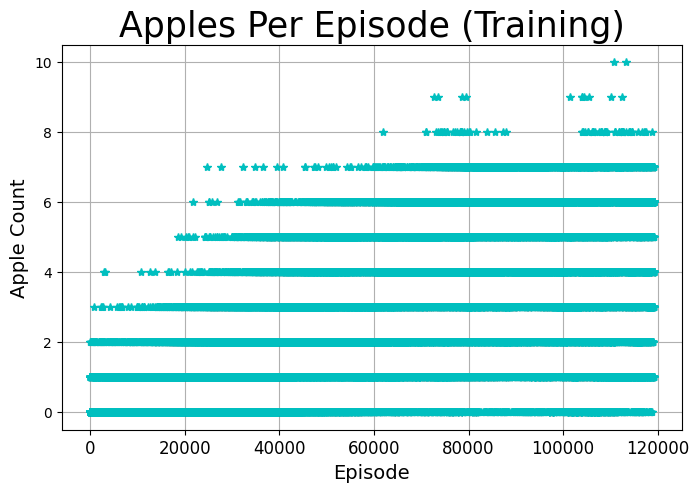

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(apple_list_training, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Apple Count', fontsize=14)
plt.title('Apples Per Episode (Training)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

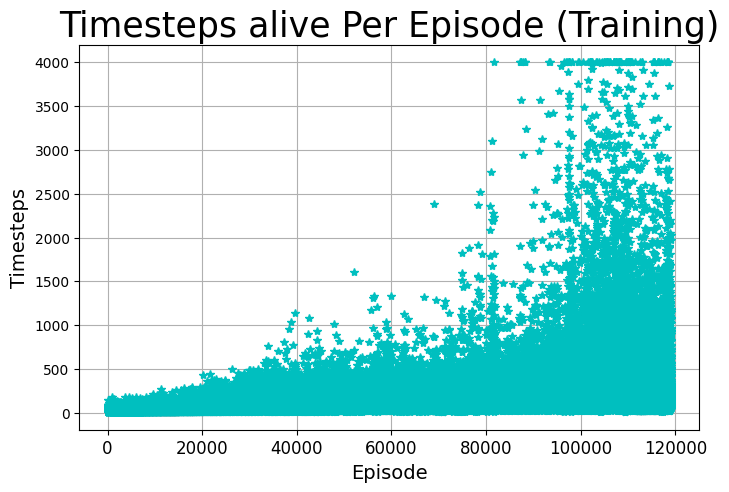

In [19]:
import matplotlib.pyplot as plt
# Plotting the Rewards
plt.figure(figsize=(8, 5))
plt.plot(timestep_list_training, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Timesteps', fontsize=14)
plt.title('Timesteps alive Per Episode (Training)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

### Playing the snake environment using greedy policy

In [28]:
env = Snake()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, test= True)
agent.load("/kaggle/working/billodal_syadavil_akhilshr_project_dqn.h5")
EPISODES = 10
reward_list_testing = []
apple_list_testing = []
timestep_list_testing = []
action_list = []
done = False


In [29]:
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    episode_reward = 0
    timestep = 0
    episode_action_list = []
    
    while(not done):
        action = agent.act(state)
        episode_action_list.append(action)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        episode_reward += reward
        timestep+=1
        if done:
            if e % 1 == 0:
                print("Episode: {}/{}, Episode Reward: {}, Epsilon: {:.2}, Episode Apple Count: {}, Timestep: {}"
                      .format(e, EPISODES, episode_reward, agent.epsilon, env.apple_count, timestep))
            reward_list_testing.append(episode_reward)
            apple_list_testing.append(env.apple_count)
            timestep_list_testing.append(timestep)
    action_list.append(episode_action_list)

env.close()

Episode: 0/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 1/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 2/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 3/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 4/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 5/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 6/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 7/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 8/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0, Episode Apple Count: 10, Timestep: 211
Episode: 9/10, Episode Reward: 7165.1036644924125, Epsilon: 0.0,

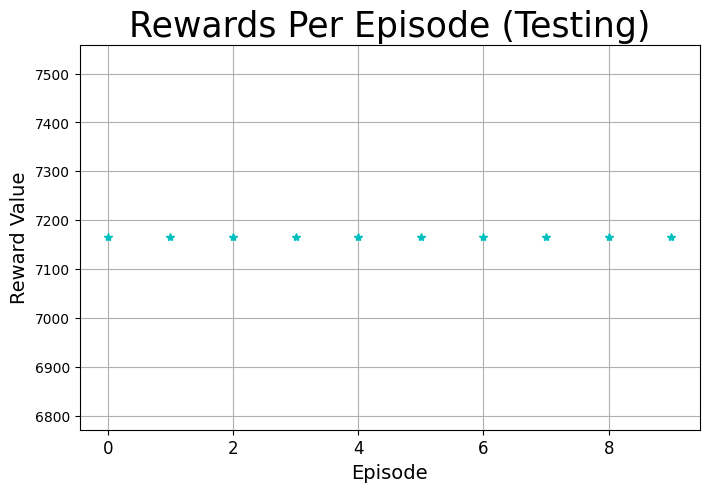

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(reward_list_testing, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Reward Value', fontsize=14)
plt.title('Rewards Per Episode (Testing)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

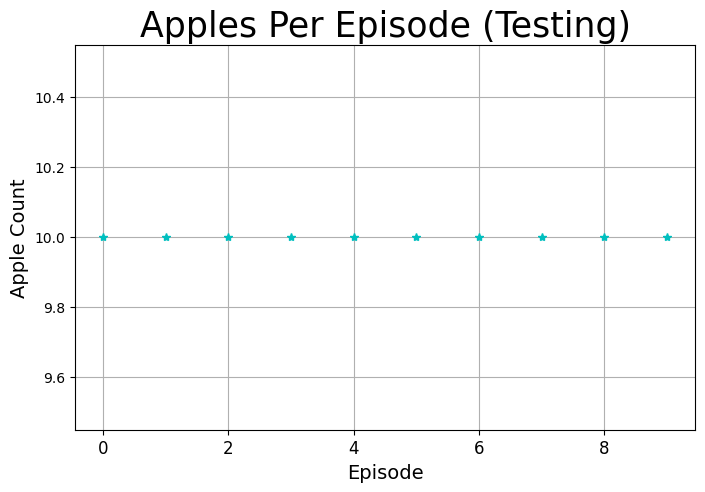

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(apple_list_testing, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Apple Count', fontsize=14)
plt.title('Apples Per Episode (Testing)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

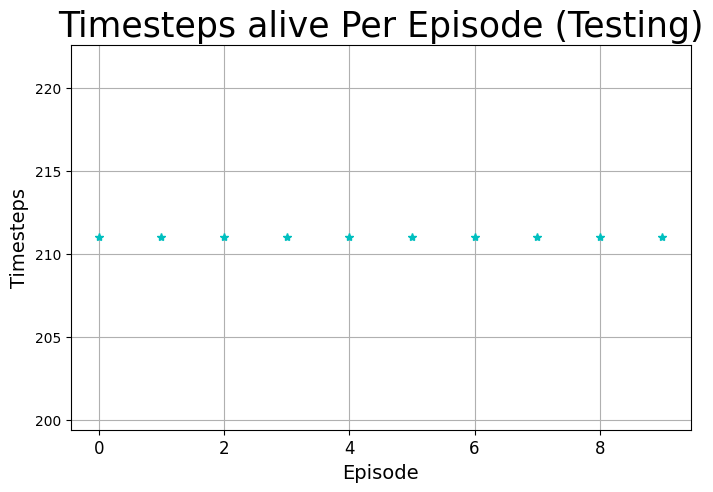

In [32]:
import matplotlib.pyplot as plt
# Plotting the Rewards
plt.figure(figsize=(8, 5))
plt.plot(timestep_list_testing, 'c*')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Timesteps', fontsize=14)
plt.title('Timesteps alive Per Episode (Testing)', fontsize=25)
plt.xticks(fontsize=12)
plt.grid()
plt.show()